<a href="https://colab.research.google.com/github/ahitagnied/deep-learning/blob/main/01-deep-neural-networks/014-lstm/lstm_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [287]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

In [288]:
df = pd.read_csv('AMZN.csv')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


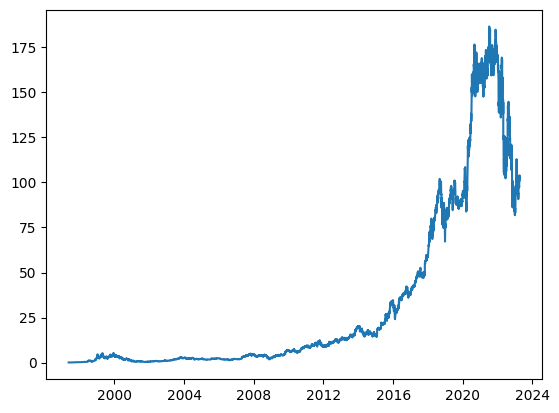

In [289]:
plt.plot(df['Date'], df['Close'])
plt.show()

In [290]:
# First create your base dataframe
data = df.iloc[7:].reset_index(drop=True)  # Reset index after slicing, and drop old index labels

# Then add lagged columns
for i in range(6, -1, -1):
    col = df['Close'].iloc[i:].reset_index(drop=True)  # Reset index here too
    data[f"Close(t-{7-i})"] = col

data.head()

,Date,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
0,1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1,1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
2,1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
3,1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
4,1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [291]:
data = data.iloc[:, 1:]

In [292]:
data = data.to_numpy()

In [293]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

In [294]:
print(data.shape)

(6509, 8)


In [295]:
X = data[:, 1:]
y = data[:, 0]
X.shape, y.shape

((6509, 7), (6509,))

In [296]:
X = np.flip(X, axis=1) # Fix X to be from oldest to newest data for LSTM
X.shape

(6509, 7)

In [297]:
split_idx = int(len(X) * 0.95)

In [298]:
xTrain = X[:split_idx]
yTrain = y[:split_idx]
xTest = X[split_idx:]
yTest = y[split_idx:]

xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((6183, 7), (326, 7), (6183,), (326,))

In [299]:
# Convert numpy to tensor
xtrain = xTrain.reshape((-1, 7, 1))
xtest = xTest.reshape((-1, 7, 1))
ytrain = yTrain.reshape((-1, 1))
ytest = yTest.reshape((-1, 1))

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((6183, 7, 1), (6183, 1), (326, 7, 1), (326, 1))

In [300]:
xtrain = torch.tensor(xtrain.copy()).float()
ytrain = torch.tensor(ytrain).float()
xtest = torch.tensor(xtest.copy()).float()
ytest = torch.tensor(ytest).float()

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

(torch.Size([6183, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([326, 1]))

In [301]:
from torch.utils.data import Dataset

# Make a dataset to pass into Dataloader
class TimeSeriesData(Dataset):
  def __init__(self, X, y):
    self.x = X
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

train_set = TimeSeriesData(xtrain, ytrain)
test_set = TimeSeriesData(xtest, ytest)

In [302]:
from torch.utils.data import DataLoader

bs = 16

train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [303]:
class LSTM(nn.Module):
    def __init__(self, inputs, hiddens, num_stacked_layers, dropout=0.2):  # Add dropout
        super().__init__()
        self.hiddens = hiddens
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(inputs, hiddens, num_stacked_layers,
                           batch_first=True,
                           dropout=dropout)  # Add dropout between LSTM layers
        self.linear = nn.Linear(hiddens, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hiddens).to(x.device)
        c0 = torch.zeros(self.num_stacked_layers, x.size(0), self.hiddens).to(x.device)

        x, _ = self.lstm(x, (h0, c0))
        x = self.linear(x[:, -1, :])
        return x

# Reinitialize with dropout
model = LSTM(1, 4, 1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


LSTM(
  (lstm): LSTM(1, 4, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)

Epoch: 00 | Train Loss: 0.4353 | Test Loss: 0.1520
Epoch: 02 | Train Loss: 0.0084 | Test Loss: 0.0200
Epoch: 04 | Train Loss: 0.0019 | Test Loss: 0.0091
Epoch: 06 | Train Loss: 0.0005 | Test Loss: 0.0092
Epoch: 08 | Train Loss: 0.0004 | Test Loss: 0.0056
Epoch: 10 | Train Loss: 0.0003 | Test Loss: 0.0043
Epoch: 12 | Train Loss: 0.0003 | Test Loss: 0.0041
Epoch: 14 | Train Loss: 0.0002 | Test Loss: 0.0033
Epoch: 16 | Train Loss: 0.0002 | Test Loss: 0.0029
Epoch: 18 | Train Loss: 0.0002 | Test Loss: 0.0030
Epoch: 20 | Train Loss: 0.0002 | Test Loss: 0.0027
Epoch: 22 | Train Loss: 0.0002 | Test Loss: 0.0024
Epoch: 24 | Train Loss: 0.0002 | Test Loss: 0.0025
Epoch: 26 | Train Loss: 0.0002 | Test Loss: 0.0021
Epoch: 28 | Train Loss: 0.0002 | Test Loss: 0.0022
Epoch: 30 | Train Loss: 0.0002 | Test Loss: 0.0022
Epoch: 32 | Train Loss: 0.0001 | Test Loss: 0.0021
Epoch: 34 | Train Loss: 0.0001 | Test Loss: 0.0019
Epoch: 36 | Train Loss: 0.0001 | Test Loss: 0.0022
Epoch: 38 | Train Loss: 0.0001 

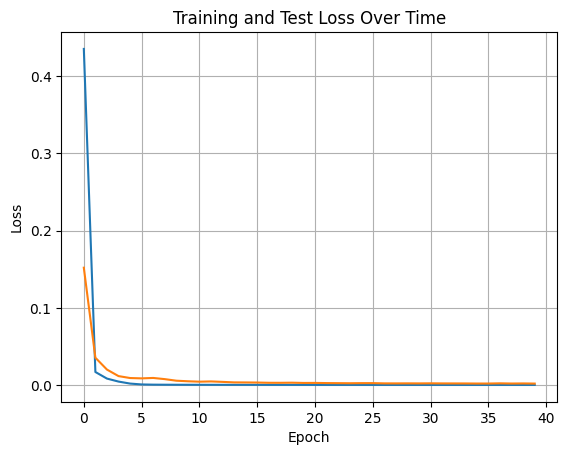

In [304]:
epochs = 40
lr = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr)
loss_fn = nn.MSELoss()

# Lists to store loss history
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()  # No need for train(True)
    train_loss = 0
    num_train_batches = 0

    for x, y in train_loader:  # No need to track batch number manually
        x = x.to(device)
        y = y.to(device)

        optimiser.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimiser.step()

        train_loss += loss.item()  # Use .item() to prevent memory leaks
        num_train_batches += 1

    avg_train_loss = train_loss / num_train_batches

    # Testing phase
    model.eval()  # Better than train(False)
    test_loss = 0
    num_test_batches = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_fn(output, y)
            test_loss += loss.item()
            num_test_batches += 1

    avg_test_loss = test_loss / num_test_batches

    # Store losses
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    if epoch % 2 == 0:
        print(f"Epoch: {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

# Optionally plot the learning curves
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.grid(True)
plt.show()

In [324]:
test_pred = model(xtest.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((xtest.shape[0], 8))
dummies[:, 0] = test_pred

test_pred = scaler.inverse_transform(dummies)

In [325]:
test_pred = test_pred[:, 0]

In [337]:
dummies = np.zeros((xtest.shape[0], 8))
dummies[:, 0] = ytest.to(device).cpu().numpy().flatten()

ytest = scaler.inverse_transform(dummies)

In [338]:
ytest = ytest[:, 0]

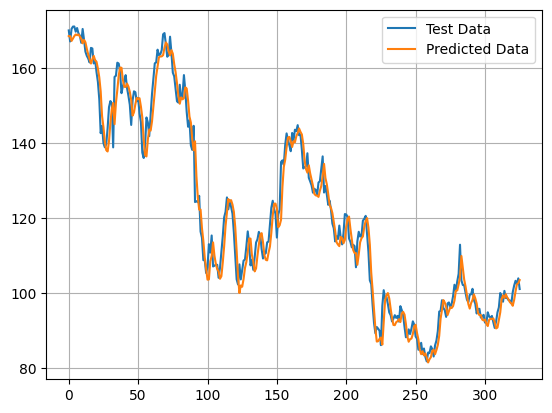

In [339]:
plt.plot(ytest, label="Test Data")
plt.plot(test_pred, label="Predicted Data")
plt.legend()
plt.grid()
plt.show()